
# **Setting Everything Up**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
RANDOM_SEED = 42 # for reproducibility
MAX_K_CLUSTERS = 50 # max number of clusters (more on this later...)

!pip install pyspark
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=92dd730529508dc0c61af040ac2f2e047d921768c01ba987eec3a8d257487527
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:a

In [ ]:
# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Install ngrok
!pip install pyngrok

!ngrok authtoken NGROK_KEY

from pyngrok import ngrok

# Open a ngrok tunnel on the port 4050 where Spark is running
port = '4050'
public_url = ngrok.connect(port).public_url

# Point Colaboratory to our Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

raw_data = spark.read.load('gdrive/My Drive/Masters Semester 2/Avalanche_Predictor/avalanche-record-CAIC.csv',
                         format="csv",
                         sep=",",
                         inferSchema="true",
                         header="true"
                         )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=5b50940421626aff1b1310cc8ecb87fb7bb5bbfaaadf9e1a12680a579d04e8ef
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


Mounted at /content/gdrive


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://68de-35-223-126-211.ngrok-free.app" -> "http://127.0.0.1:4050"


In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.app.submitTime', '1688549872017'),
 ('spark.app.name', 'PySparkTutorial'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.app.id', 'local-1688549877276'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.driver.host', '1c28f7b64abe'),
 ('spark.app.startTime', '1688549872362'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs

In [ ]:
raw_data.cache()

DataFrame[Observation ID: string, Date: string, Date Known: string, Landmark: string, First Name: string, Last Name: string, #: string, Elev: string, Asp: string, Type: string, Trig: string, Secondary Trigger: string, sizeR: string, sizeD: string, Incident: string, Area: string, Location: string, Description: string, Comments: string, Sliding Sfc: string, Status: string, Locked: string, Weak Layer: string, Avg Width: string, Width Units: string, Avg Vertical: string, Vertical Units: string, Avg Crown: string, Crown Units: string, Terminus: string]

In [ ]:
print(raw_data.columns)

['Observation ID', 'Date', 'Date Known', 'Landmark', 'First Name', 'Last Name', '#', 'Elev', 'Asp', 'Type', 'Trig', 'Secondary Trigger', 'sizeR', 'sizeD', 'Incident', 'Area', 'Location', 'Description', 'Comments', 'Sliding Sfc', 'Status', 'Locked', 'Weak Layer', 'Avg Width', 'Width Units', 'Avg Vertical', 'Vertical Units', 'Avg Crown', 'Crown Units', 'Terminus']


In [ ]:
raw_data.printSchema()

root
 |-- Observation ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Date Known: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- First Name: string (nullable = true)
 |-- Last Name: string (nullable = true)
 |-- #: string (nullable = true)
 |-- Elev: string (nullable = true)
 |-- Asp: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Trig: string (nullable = true)
 |-- Secondary Trigger: string (nullable = true)
 |-- sizeR: string (nullable = true)
 |-- sizeD: string (nullable = true)
 |-- Incident: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Comments: string (nullable = true)
 |-- Sliding Sfc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Locked: string (nullable = true)
 |-- Weak Layer: string (nullable = true)
 |-- Avg Width: string (nullable = true)
 |-- Width Units: string (nullable = true)
 |-- 

In [ ]:
raw_data.show(5, truncate=False)

+------------------------------------+-----------------------------------------------------------------+----------+--------+----------+---------+---+----+---+----+----+-----------------+-----+-----+--------+---------------------+---------------------------+------------------------------------------------------------------------------------------------+-------------------------------------+-----------+---------+------+----------+---------+-----------+------------+--------------+---------+-----------+--------+
|Observation ID                      |Date                                                             |Date Known|Landmark|First Name|Last Name|#  |Elev|Asp|Type|Trig|Secondary Trigger|sizeR|sizeD|Incident|Area                 |Location                   |Description                                                                                     |Comments                             |Sliding Sfc|Status   |Locked|Weak Layer|Avg Width|Width Units|Avg Vertical|Vertical Units|Avg 

# **Pre Processing the Data**

In [ ]:
selected_data = raw_data.select(['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area','Description', 'Comments' ,'sizeD'])
selected_data.show(5, truncate=False)

+----+---+----+----+-----+---------------------+------------------------------------------------------------------------------------------------+-------------------------------------+-----+
|Elev|Asp|Type|Trig|sizeR|Area                 |Description                                                                                     |Comments                             |sizeD|
+----+---+----+----+-----+---------------------+------------------------------------------------------------------------------------------------+-------------------------------------+-----+
| >TL| W | SS | N  | R1  | Front Range         | -                                                                                              | -                                   | D1.5|
| >TL| E | WS | N  | R2  | Gunnison            | Large slab avalanche off Mt Owen with debris to Green Lake. Appeared to be cornice triggered.  | Probably triggered by a cornice fall| D2.5|
| >TL| E | WL | AS | -   | Vail & Summit County| 1

In [ ]:
# This function is responsible to implement the pipeline above for transforming categorical features into numerical ones
def create_pipeline(imputed_df):

    """
    Args:
        - df: the input dataframe

    Return:
        - transformer: the pipeline of transformation fit to `df` (for future usage)
        - df_transformed: the dataframe transformed according to the pipeline
    """

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

    # 2. Create the one-hot encoder for the list of features just indexed (this encoder will keep any unseen label in the future)
    encoder = OneHotEncoder(inputCols=['Elev_imputed', 'Asp_imputed', 'Type_imputed', 'Trig_imputed', 'sizeR_imputed', 'Area_imputed'],
                                    outputCols=["{}_encoded".format(a) for a in ['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area']],
                                    handleInvalid="keep")

    # 3. Assemble all the features into a single vector
    assembler = VectorAssembler(inputCols=encoder.getOutputCols(), outputCol="features")

    # 4. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=[encoder] + [assembler])

    # 5. Transform the input dataframe accordingly
    transformer = pipeline.fit(imputed_df)
    df_transformed = transformer.transform(imputed_df)

    # 7. Eventually, return both the transformed dataframe and the transformer object for future transformations
    return transformer, df_transformed

In [ ]:
# replace all '-' in dataframe to null
from pyspark.sql.functions import *

for i in ['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area', 'sizeD']:
  selected_data = selected_data.withColumn(i, regexp_replace(i, '-', ''))

# 1. Create a list of indexers, i.e., one for each categorical feature
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep").fit(selected_data) for c in ['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area', 'sizeD']]

for index in indexers:
  selected_data = index.transform(selected_data).withColumn(index.getOutputCol(), when(col(index.getOutputCol()) == index.labels.index(' '), None).otherwise(col(index.getOutputCol())))
selected_data.show(5)

+----+---+----+----+-----+--------------------+--------------------+--------------------+-----+------------+-----------+------------+------------+-------------+------------+-------------+
|Elev|Asp|Type|Trig|sizeR|                Area|         Description|            Comments|sizeD|Elev_indexed|Asp_indexed|Type_indexed|Trig_indexed|sizeR_indexed|Area_indexed|sizeD_indexed|
+----+---+----+----+-----+--------------------+--------------------+--------------------+-----+------------+-----------+------------+------------+-------------+------------+-------------+
| >TL|  W|  SS|   N|   R1|         Front Range|                   -|                   -| D1.5|         0.0|        5.0|         0.0|         0.0|          1.0|         2.0|          2.0|
| >TL|  E|  WS|   N|   R2|            Gunnison| Large slab avala...| Probably trigger...| D2.5|         0.0|        0.0|         5.0|         0.0|          0.0|         1.0|          3.0|
| >TL|  E|  WL|  AS|     | Vail & Summit Co...| 1 backcountr

In [ ]:
from pyspark.ml.feature import Imputer
# now we fill in all the empty features to the mode of that feature
imputer = Imputer(
    inputCols = ['Elev_indexed', 'Asp_indexed', 'Type_indexed', 'Trig_indexed', 'sizeR_indexed', 'Area_indexed', 'sizeD_indexed'],
    outputCols = ["{}_imputed".format(a) for a in ['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area', 'sizeD']]
).setStrategy("mode")
all_data_imputed = imputer.fit(selected_data).transform(selected_data)
data_imputed = imputer.fit(selected_data).transform(selected_data).select(["{}_imputed".format(a) for a in ['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area', 'sizeD']])
data_imputed = data_imputed.withColumnRenamed('sizeD_imputed', "label")
data_imputed.show(10)

+------------+-----------+------------+------------+-------------+------------+-----+
|Elev_imputed|Asp_imputed|Type_imputed|Trig_imputed|sizeR_imputed|Area_imputed|label|
+------------+-----------+------------+------------+-------------+------------+-----+
|         0.0|        5.0|         0.0|         0.0|          1.0|         2.0|  2.0|
|         0.0|        0.0|         5.0|         0.0|          0.0|         1.0|  3.0|
|         0.0|        0.0|         2.0|         1.0|          0.0|         3.0|  1.0|
|         2.0|        7.0|         0.0|         0.0|          1.0|         4.0|  1.0|
|         0.0|        2.0|         5.0|         9.0|          0.0|         3.0|  2.0|
|         0.0|        1.0|         4.0|         1.0|          1.0|         0.0|  1.0|
|         0.0|        1.0|         0.0|         1.0|          1.0|         3.0|  1.0|
|         0.0|        1.0|         0.0|         1.0|          0.0|         3.0|  2.0|
|         0.0|        6.0|         2.0|         0.0|  

In [ ]:
ndi = data_imputed.toPandas()

Plotting 7 columns from the dataset:
[`Area_imputed`, `Asp_imputed`, `Elev_imputed`, `Trig_imputed`, `Type_imputed`, `label`, `sizeR_imputed`]


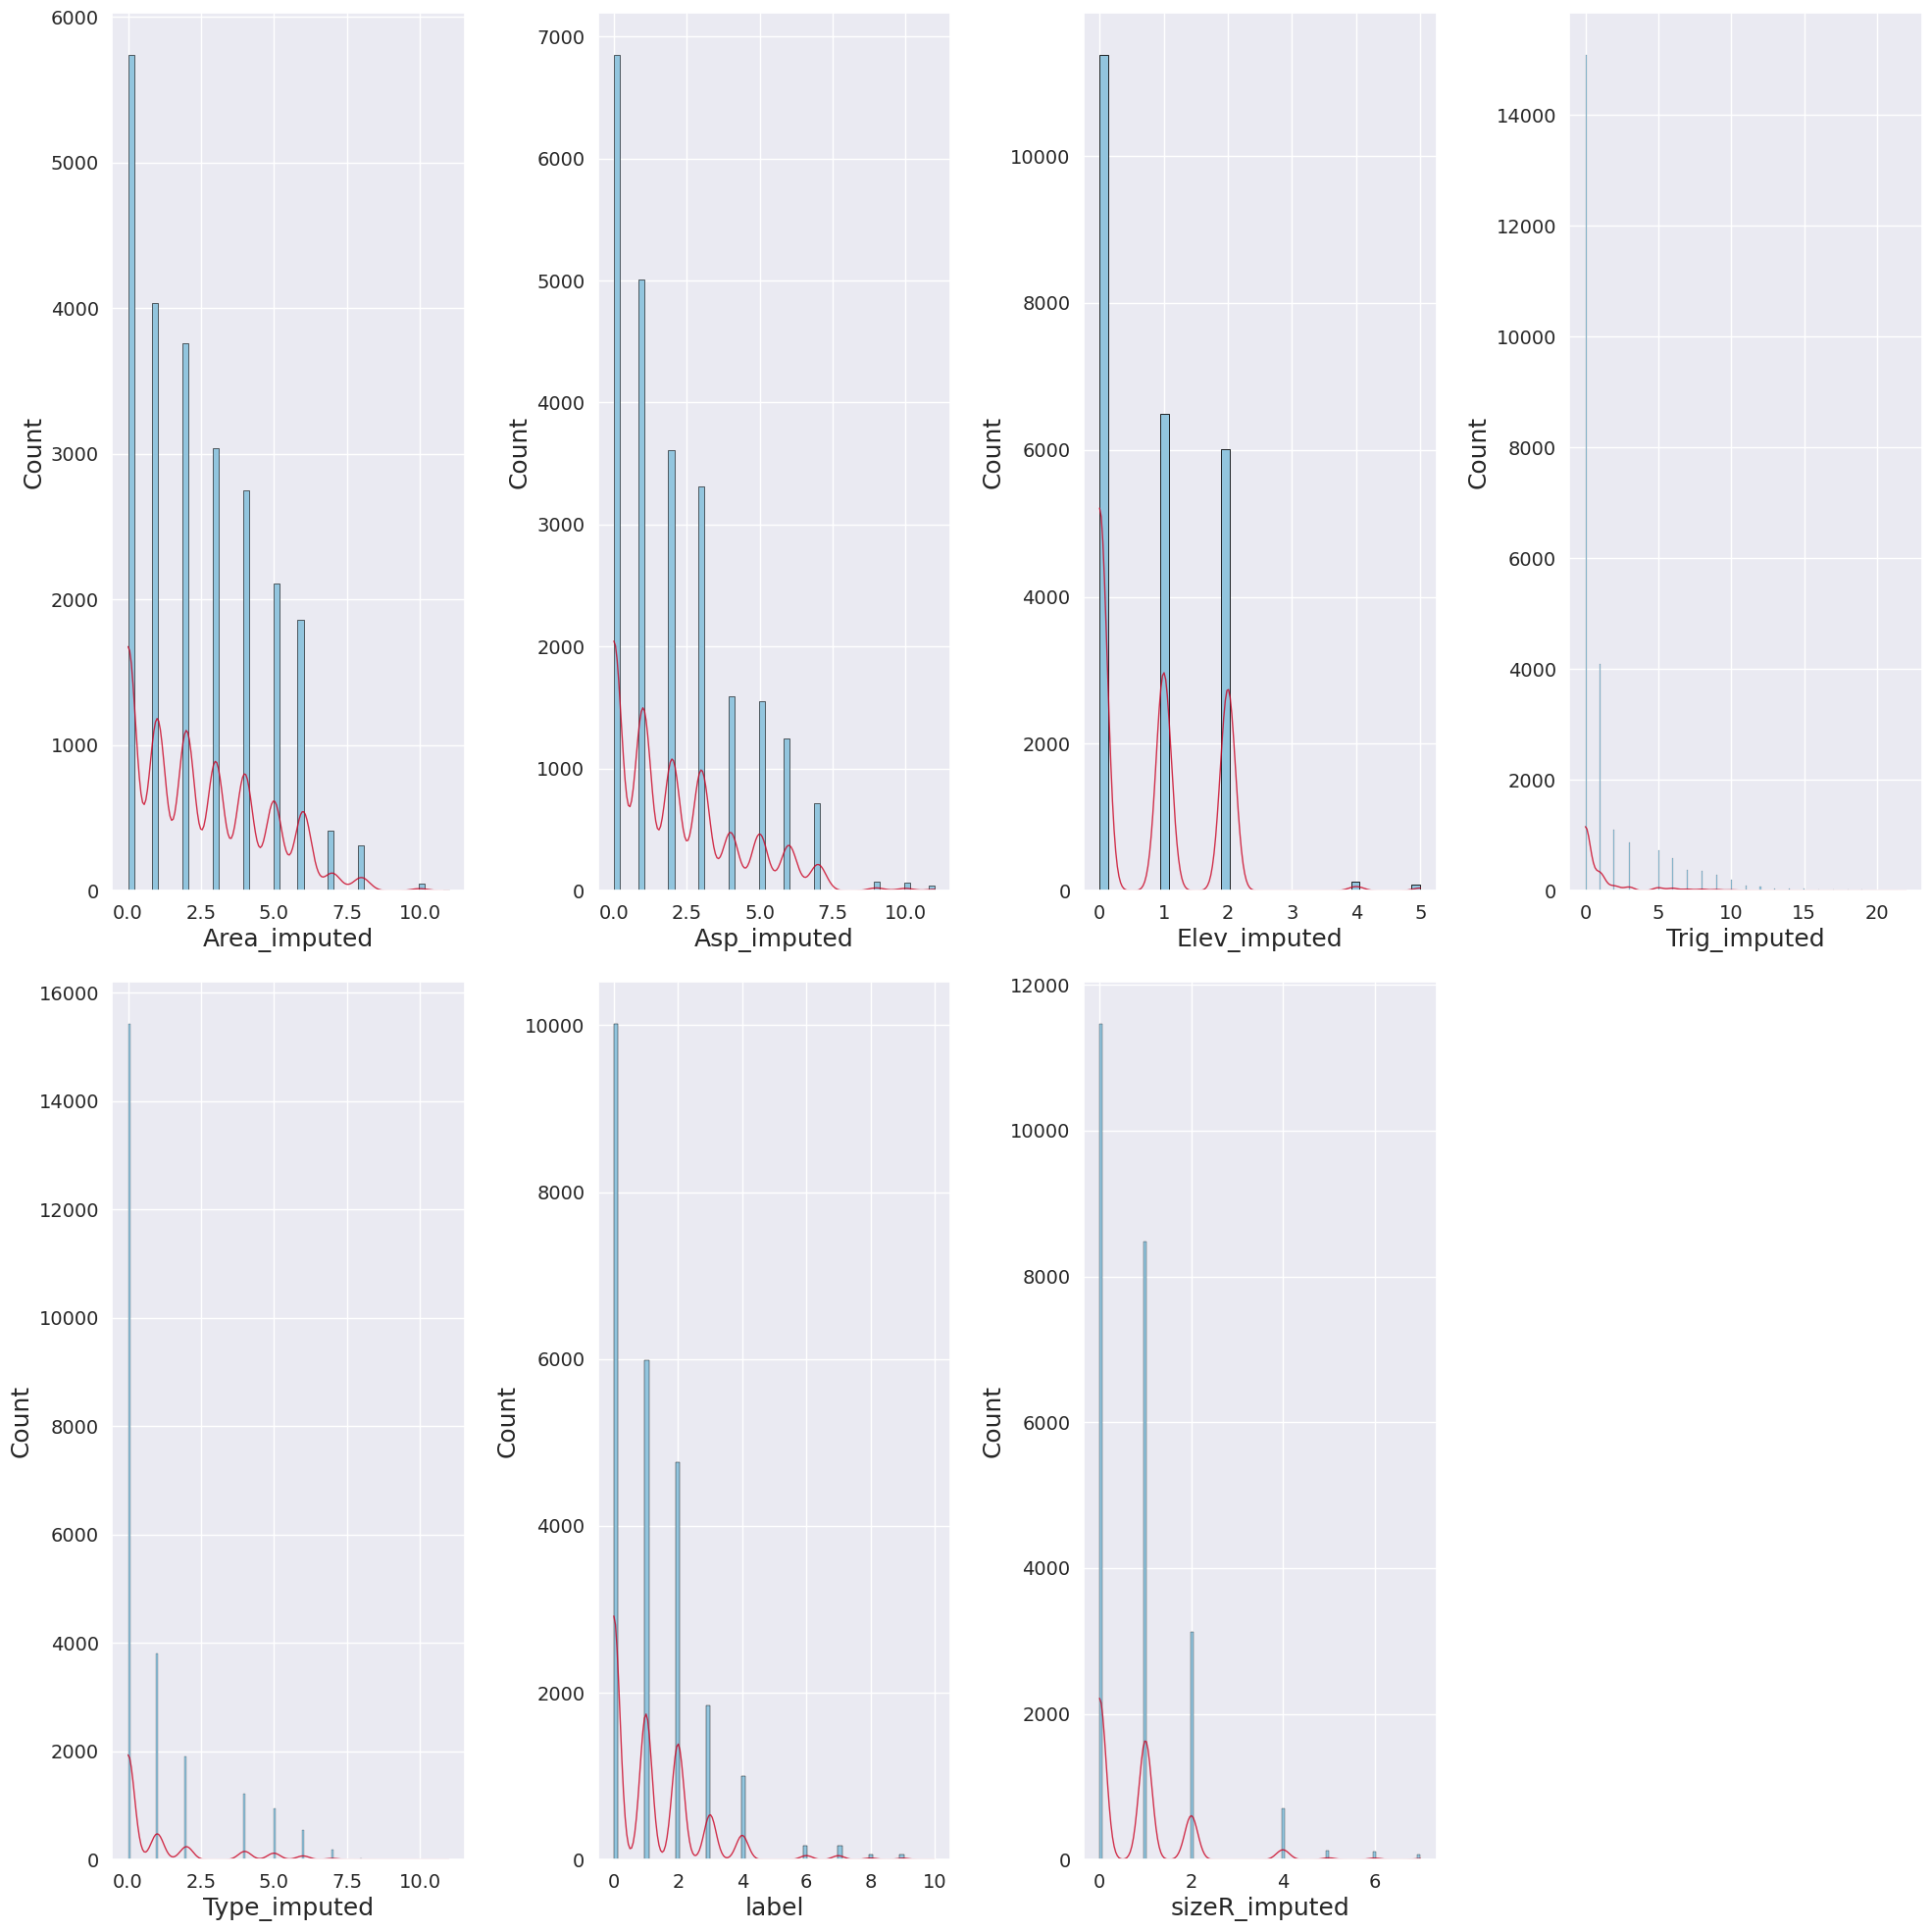

In [ ]:
# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2,
                                "xtick.labelsize":14,
                                "ytick.labelsize":14,
                                "axes.labelsize": 18
                                })

# Select only the columns which will be included in the distribution plots
PLOT_COLUMNS = sorted(["{}_imputed".format(a) for a in ['Elev', 'Asp', 'Type', 'Trig', 'sizeR', 'Area']] + ['label'])
print("Plotting {:d} columns from the dataset:\n[{:s}]".format(len(PLOT_COLUMNS),
                                                              ", ".join(["`{:s}`".format(pc) for pc in PLOT_COLUMNS])
                                                              ))
# Plot the distribution of values of each column of interest
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
fig.delaxes(axes[1][3]) # the last ax will be empty as there are 19 columns for 20 slots, so just delete it!

for i,f in enumerate(PLOT_COLUMNS):
  _ = sns.histplot(ndi[f],
                   kde=True,
                   color="#ca0020",
                   #kde_kws={"linewidth": 1},
                   line_kws={"linewidth": 1, "alpha": 0.8},
                   facecolor="#92c5de",
                   edgecolor="black",
                   ax=axes[i//n_cols, i%n_cols]
                   )

fig.tight_layout(pad=1.5)

Regression plots of 6 numerical continuous features:
[`Area_imputed`, `Asp_imputed`, `Elev_imputed`, `Trig_imputed`, `Type_imputed`, `sizeR_imputed`]


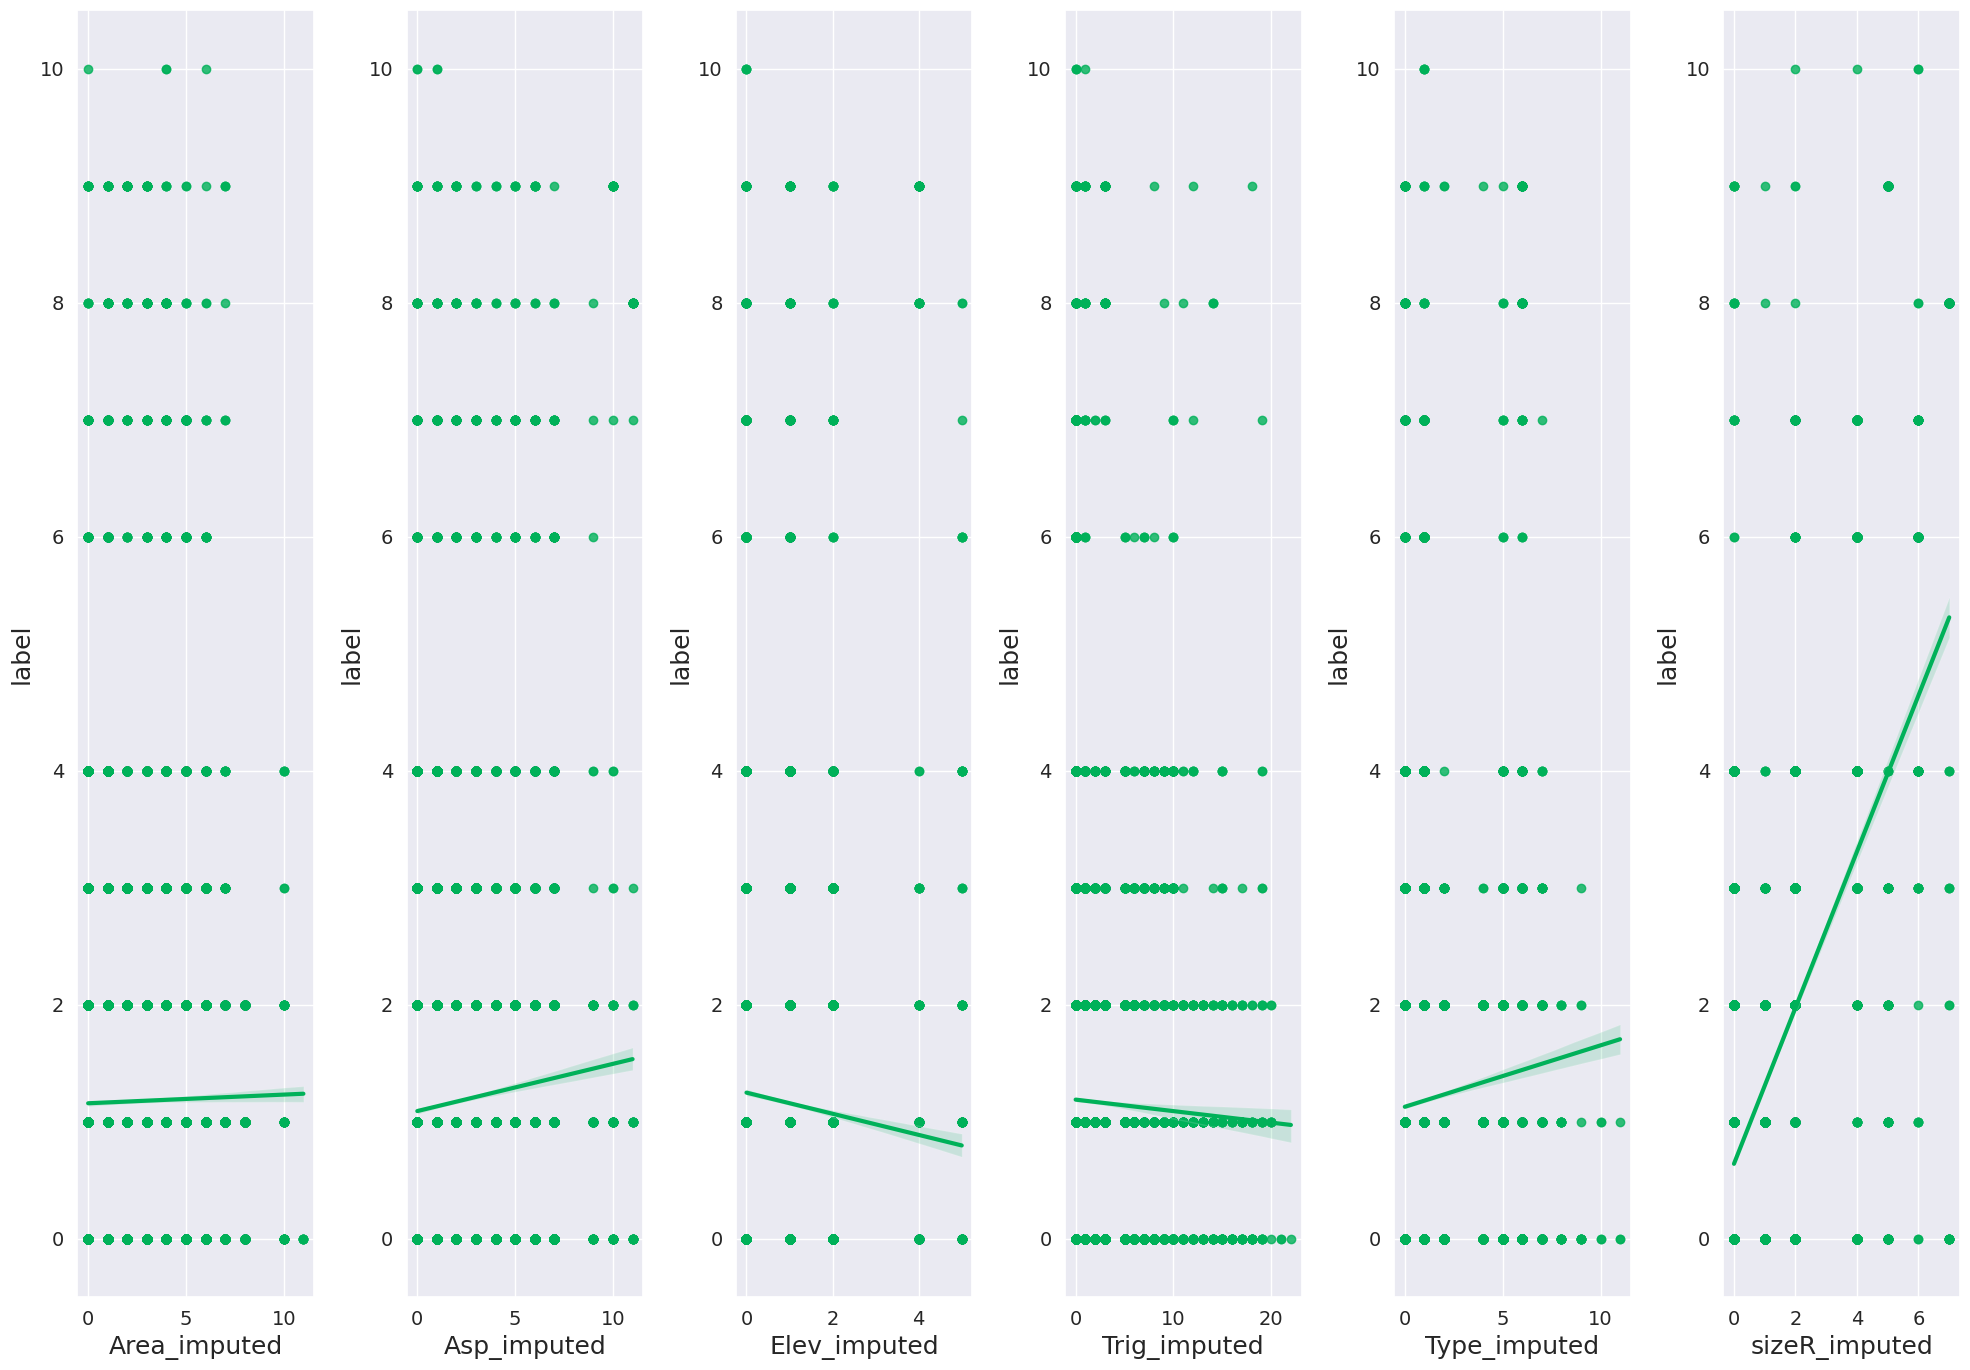

In [ ]:
FEATURES = sorted(list(set(PLOT_COLUMNS) - set(['label'])))
print("Regression plots of {:d} numerical continuous features:\n[{:s}]".format(len(FEATURES),
                                                                              ", ".join(["`{:s}`".format(ncf) for ncf in FEATURES])
                                                                              ))
# Plot the relationship between each feature (i.e., independent variable) with the target (i.e., dependent) variable
n_rows = 1
n_cols = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,14))

for i,f in enumerate(FEATURES):
  _ = sns.regplot(data=ndi,
                  x=f,
                  y="label",
                  color="#00b159",
                  ax=axes[i])

fig.tight_layout(pad=1.5)

# **Prediction Models**


## Split the data into training / test sets

In [ ]:
(trainingData, testData) = data_imputed.randomSplit([0.7, 0.3])

(transformer, oh_train_df) = create_pipeline(trainingData)

oh_train_df.show(5, truncate=False)

+------------+-----------+------------+------------+-------------+------------+-----+-------------+--------------+--------------+--------------+-------------+--------------+------------------------------------------------+
|Elev_imputed|Asp_imputed|Type_imputed|Trig_imputed|sizeR_imputed|Area_imputed|label|Elev_encoded |Asp_encoded   |Type_encoded  |Trig_encoded  |sizeR_encoded|Area_encoded  |features                                        |
+------------+-----------+------------+------------+-------------+------------+-----+-------------+--------------+--------------+--------------+-------------+--------------+------------------------------------------------+
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |(6,[0],[1.0])|(12,[0],[1.0])|(12,[0],[1.0])|(23,[0],[1.0])|(8,[0],[1.0])|(12,[0],[1.0])|(73,[0,6,18,30,53,61],[1.0,1.0,1.0,1.0,1.0,1.0])|
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |(6,[0],[1.0])|(12,[0],[

In [ ]:
# Here, we use the same transformer as the one returned by the `to_numerical` function above yet applied to the test set
oh_test_df = transformer.transform(testData)

oh_test_df.show(5)

+------------+-----------+------------+------------+-------------+------------+-----+-------------+--------------+--------------+--------------+-------------+--------------+--------------------+
|Elev_imputed|Asp_imputed|Type_imputed|Trig_imputed|sizeR_imputed|Area_imputed|label| Elev_encoded|   Asp_encoded|  Type_encoded|  Trig_encoded|sizeR_encoded|  Area_encoded|            features|
+------------+-----------+------------+------------+-------------+------------+-----+-------------+--------------+--------------+--------------+-------------+--------------+--------------------+
|         0.0|        0.0|         0.0|         0.0|          0.0|         0.0|  0.0|(6,[0],[1.0])|(12,[0],[1.0])|(12,[0],[1.0])|(23,[0],[1.0])|(8,[0],[1.0])|(12,[0],[1.0])|(73,[0,6,18,30,53...|
|         0.0|        0.0|         0.0|         0.0|          0.0|         0.0|  0.0|(6,[0],[1.0])|(12,[0],[1.0])|(12,[0],[1.0])|(23,[0],[1.0])|(8,[0],[1.0])|(12,[0],[1.0])|(73,[0,6,18,30,53...|
|         0.0|        0.0

## Descision Tree Classifier

In [ ]:
# single large descision tree
tree_train = trainingData
tree_test = testData
tree_train.show(5, truncate=False)
# separate out the features from the labe and create a vector assembler
from pyspark.ml.feature import VectorAssembler
feature_list = []
for col in tree_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

# now we create the tree and add it to the pipeline
from pyspark.ml.classification import DecisionTreeClassifier
rf = DecisionTreeClassifier(labelCol="label", featuresCol="features")

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

cvModel = pipeline.fit(tree_train)
predictions = cvModel.transform(tree_test)

+------------+-----------+------------+------------+-------------+------------+-----+
|Elev_imputed|Asp_imputed|Type_imputed|Trig_imputed|sizeR_imputed|Area_imputed|label|
+------------+-----------+------------+------------+-------------+------------+-----+
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
+------------+-----------+------------+------------+-------------+------------+-----+
only showing top 5 rows



In [ ]:
# get the accuracy from the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % (accuracy))

treeModel = cvModel.stages[1]
# summary only

print(treeModel)

Accuracy = 0.552632 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2ef1c59ff036, depth=5, numNodes=29, numClasses=11, numFeatures=6


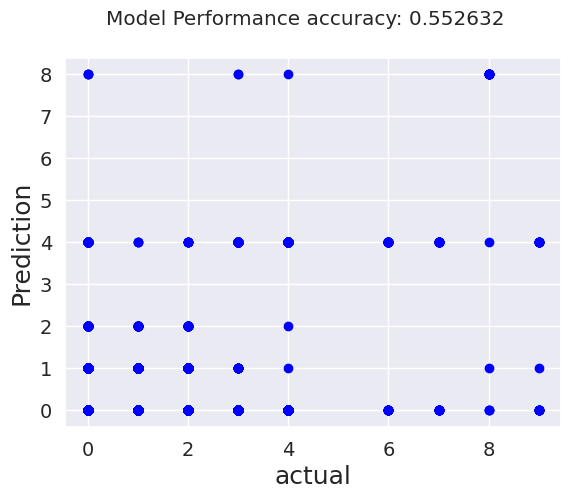

In [ ]:
# show prediction vs ground truth graph
import matplotlib.pyplot as plt
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(tree_test)
rfResult = rfPred.toPandas()
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('actual')
plt.ylabel('Prediction')
plt.suptitle("Model Performance accuracy: %f" % rmse)
plt.show()

## Random Forest

In [ ]:
# random forest experiment
# inspiration from this blog post https://www.silect.is/blog/random-forest-models-in-spark-ml/
tree_train = trainingData
tree_test = testData
tree_train.show(5, truncate=False)
# this follows the same logic as the single descision tree
from pyspark.ml.feature import VectorAssembler
feature_list = []
for col in tree_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# for random forest we make a parameter grid to try and get the best model for our data
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 30, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 13, num = 3)]) \
    .build()

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel = crossval.fit(tree_train)
predictions = cvModel.transform(tree_test)


+------------+-----------+------------+------------+-------------+------------+-----+
|Elev_imputed|Asp_imputed|Type_imputed|Trig_imputed|sizeR_imputed|Area_imputed|label|
+------------+-----------+------------+------------+-------------+------------+-----+
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
|0.0         |0.0        |0.0         |0.0         |0.0          |0.0         |0.0  |
+------------+-----------+------------+------------+-------------+------------+-----+
only showing top 5 rows



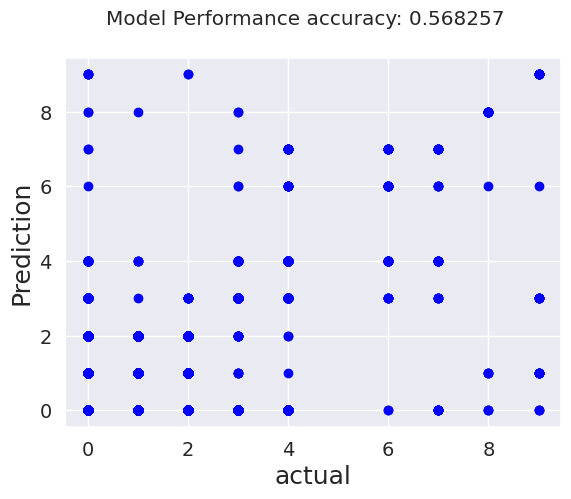

In [ ]:
# see ground truth vs predictions
import matplotlib.pyplot as plt
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(tree_test)
rfResult = rfPred.toPandas()
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('actual')
plt.ylabel('Prediction')
plt.suptitle("Model Performance accuracy: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

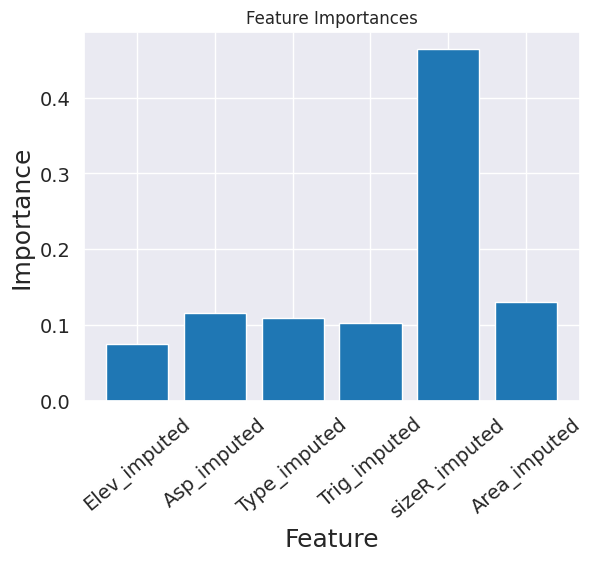

In [ ]:
# show the feature importnaces for predicting the avalanche
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [ ]:
treeModel = cvModel.bestModel.stages[1]
# summary only
print(treeModel)

RandomForestClassificationModel: uid=RandomForestClassifier_5118f9b3d57e, numTrees=20, numClasses=11, numFeatures=6


## Logistic Regression

### Without scailing

In [ ]:
#from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression


# `lr` is still the LinearRegressor object we set up above (the only difference here is that now `features` refers to the whole feature vector)
lr = LogisticRegression(featuresCol="features", labelCol="label") # Analogous to lr = LinearRegression()
# Train the actual model on our training set `train`
lr_model_1 = lr.fit(oh_train_df)

In [ ]:
oh_test_df.show(5)

test = oh_test_df.select(["features", "label"])
test.show(5)

+------------+-----------+------------+------------+-------------+------------+-----+-------------+--------------+--------------+--------------+-------------+--------------+--------------------+
|Elev_imputed|Asp_imputed|Type_imputed|Trig_imputed|sizeR_imputed|Area_imputed|label| Elev_encoded|   Asp_encoded|  Type_encoded|  Trig_encoded|sizeR_encoded|  Area_encoded|            features|
+------------+-----------+------------+------------+-------------+------------+-----+-------------+--------------+--------------+--------------+-------------+--------------+--------------------+
|         0.0|        0.0|         0.0|         0.0|          0.0|         0.0|  0.0|(6,[0],[1.0])|(12,[0],[1.0])|(12,[0],[1.0])|(23,[0],[1.0])|(8,[0],[1.0])|(12,[0],[1.0])|(73,[0,6,18,30,53...|
|         0.0|        0.0|         0.0|         0.0|          0.0|         0.0|  0.0|(6,[0],[1.0])|(12,[0],[1.0])|(12,[0],[1.0])|(23,[0],[1.0])|(8,[0],[1.0])|(12,[0],[1.0])|(73,[0,6,18,30,53...|
|         0.0|        0.0

In [ ]:
# `lr_model` is a Transformer which can be used to "transform" our test set
lr_predictions = lr_model_1.transform(test)

print(lr_predictions.count())
# `lr_predictions` is a dataframe containing (among other things) the predictions made by `lr_model` on the test set
lr_predictions.select("features", "prediction", "label").show(15)

7296
+--------------------+----------+-----+
|            features|prediction|label|
+--------------------+----------+-----+
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
|(73,[0,6,18,30,53...|       0.0|  0.0|
+--------------------+----------+-----+
only showing top 15 rows



In [ ]:
def evaluate_model(predictions, metric="accuracy"):

    from pyspark.ml.evaluation import MulticlassClassificationEvaluator

    evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                                  predictionCol="prediction",
                                                  metricName=metric)

    return evaluator.evaluate(predictions)

In [ ]:
print("***** Test Set *****")
print("accuracy: {:.3f}".format(evaluate_model(lr_predictions)))
print("log loss: {:.3f}".format(evaluate_model(lr_predictions, metric="logLoss")))
print("truePositiveRateByLabel: {:.3f}".format(evaluate_model(lr_predictions, metric="truePositiveRateByLabel")))
print("***** Test Set *****")

***** Test Set *****
accuracy: 0.569
log loss: 1.048
truePositiveRateByLabel: 0.824
***** Test Set *****


In [ ]:
# Print the coefficients and intercept for multinomial logistic regression

trainingSummary = lr_model_1.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.3694783232550989
label 1: 0.16932603000714455
label 2: 0.03386941377010302
label 3: 0.015475883415011608
label 4: 0.020150506872317932
label 5: 0.002399088346428357
label 6: 0.0017408007683534425
label 7: 0.0003584657665192974
label 8: 0.0011344638165751134
label 9: 0.0
True positive rate by label:
label 0: 0.8379840546697038
label 1: 0.7602772466539197
label 2: 0.0885036496350365
label 3: 0.13275726630007856
label 4: 0.3803418803418803
label 5: 0.4722222222222222
label 6: 0.1885245901639344
label 7: 0.8837209302325582
label 8: 0.6666666666666666
label 9: 0.0
Precision by label:
label 0: 0.6201664735012117
label 1: 0.5986074520135491
label 2: 0.3890374331550802
label 3: 0.4132029339853301
label 4: 0.4517766497461929
label 5: 0.5604395604395604
label 6: 0.4423076923076923
label 7: 0.8636363636363636
label 8: 0.5365853658536586
label 9: 0.0
Recall by label:
label 0: 0.8379840546697038
label 1: 0.7602772466539197
label 2: 0.0885036496350365
label 3

In [ ]:
testingSummary = lr_predictions.summary
print(testingSummary)

<bound method DataFrame.summary of DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]>


### with scailing

In [ ]:
# Let's define a function to standardize all the features
def standardize_features(df, input_col="features", with_std=True, with_mean=True):

    from pyspark.ml.feature import StandardScaler

    # 1. Create the StandardScaler
    scaler = StandardScaler(inputCol=input_col, outputCol="std_"+input_col, withStd=with_std, withMean=with_mean)

    # 2. Compute summary statistics by fitting the StandardScaler
    scaler_model = scaler.fit(df)

    # 3. Normalize each feature to have 0-mean and unit standard deviation
    scaled_data = scaler_model.transform(df)

    # 4. Eventually, return both the scaler_model (for future transformations) and the scaled data
    return scaler_model, scaled_data

In [ ]:
# Call the function above
scaler_model, scaled_train = standardize_features(oh_train_df)

scaled_train.select(["features", "std_features", "label"]).show(5, truncate=False)

+------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# First of all, let's just setup an OLS linear regressor with no regularization term
lr = LogisticRegression(featuresCol="std_features", labelCol="label")
# Train the actual model on our training set `scaled_train`
lr_model = lr.fit(scaled_train)

In [ ]:
# Let's apply the same feature scaling to the test set
scaled_test = scaler_model.transform(test)
# Compute predictions on the test set and select only the columns of interest
lr_predictions = lr_model.transform(scaled_test)
lr_predictions.select("features", "std_features", "prediction", "label").show(5)

+--------------------+--------------------+----------+-----+
|            features|        std_features|prediction|label|
+--------------------+--------------------+----------+-----+
|(73,[0,6,18,30,53...|[1.05052714902604...|       0.0|  0.0|
|(73,[0,6,18,30,53...|[1.05052714902604...|       0.0|  0.0|
|(73,[0,6,18,30,53...|[1.05052714902604...|       0.0|  0.0|
|(73,[0,6,18,30,53...|[1.05052714902604...|       0.0|  0.0|
|(73,[0,6,18,30,53...|[1.05052714902604...|       0.0|  0.0|
+--------------------+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
# Print the coefficients and intercept for multinomial logistic regression

trainingSummary = lr_model.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.3694783232550989
label 1: 0.16932603000714455
label 2: 0.03386941377010302
label 3: 0.015475883415011608
label 4: 0.020150506872317932
label 5: 0.002399088346428357
label 6: 0.0017408007683534425
label 7: 0.0003584657665192974
label 8: 0.0011344638165751134
label 9: 0.0
True positive rate by label:
label 0: 0.8379840546697038
label 1: 0.7602772466539197
label 2: 0.0885036496350365
label 3: 0.13275726630007856
label 4: 0.3803418803418803
label 5: 0.4722222222222222
label 6: 0.1885245901639344
label 7: 0.8837209302325582
label 8: 0.6666666666666666
label 9: 0.0
Precision by label:
label 0: 0.6201664735012117
label 1: 0.5986074520135491
label 2: 0.3890374331550802
label 3: 0.4132029339853301
label 4: 0.4517766497461929
label 5: 0.5604395604395604
label 6: 0.4423076923076923
label 7: 0.8636363636363636
label 8: 0.5365853658536586
label 9: 0.0
Recall by label:
label 0: 0.8379840546697038
label 1: 0.7602772466539197
label 2: 0.0885036496350365
label 3

In [ ]:
test_result = lr_model.evaluate(scaled_test)
print("***** Test Set *****")
print("accuracy: {:.3f}".format(test_result.accuracy))
print("***** Test Set *****")
print(test_result)

***** Test Set *****
accuracy: 0.569
***** Test Set *****


# User Application

In [ ]:
# maps
elevation_map = {'>TL':0.0, 'TL':1.0, '<TL':2.0}
aspect_map = {'N': 2.0, 'NE': 1.0, 'E': 0.0, 'SE': 3.0, 'S': 6.0, 'SW': 7.0, 'W': 5.0, 'NW': 4.0}
snow_type_map = {'SS' : 0, 'HS': 1, 'WS': 5, 'WL': 2, 'L': 4, 'U': 6, 'SF':3}
transportation_map = {'N' : 0, 'AS': 1, 'AV': 2, 'AR': 9, 'AI': 16, 'AM': 8, 'AF': 11}
size_of_slope_map = {'R1': 1, 'R2': 0, 'R3':2, 'R4': 3, 'R5': 4}
area_map = {'FR': 2, 'GU':1, 'VS':3, 'AS':4, 'SA': 5, 'NSJ': 0, 'SSJ': 6, 'SF': 7, 'SC': 8}

In [ ]:
def map(user_input):

  return [elevation_map[user_input[0]], aspect_map[user_input[1]],
          snow_type_map[user_input[2]], transportation_map[user_input[3]],
          size_of_slope_map[user_input[4]], area_map[user_input[5]]]

In [ ]:
elevation_prompt = """First enter the elevation relative to the treeline you will adventure to:
                      \n <TL for less than the tree line
                      \n TL for near the tree line
                      \n >TL for over the tree line\n"""
aspect_prompt = "\nEnter the aspect of the slope (N, NE, E, SE, S, SW, W, or NW)\n"
snow_type_prompt = """Enter the type of snow on the mountains today:
                      \n L for loose snow
                      \n WL for wet loose snow
                      \n SS for soft slab
                      \n HS for hard slab
                      \n WS for wet slab
                      \n SF for slushy
                      \n and if you don't know just type U\n"""
transportation_prompt = """\nEnter your type of transportation:
                          \n input AS for skiing
                          \n AR for snowboarding
                          \n AI for snowshoeing
                          \n AF for hiking (on foot)
                          \n AM for a snowmobile
                          \n AV for any other snow vehicle
                          \n and N for the danger of a natural avalanche occuring\n"""
size_of_slope_prompt = """\nEnter how large the area of the slope will be:
                          \n R1 for extra small (ex: a shoot)
                          \n R2 for small (ex: a gully)
                          \n R3 for medium (ex: a normal sized trail)
                          \n R4 for large (ex: a bowl)
                          \n R5 for extra large (ex: an entire mountain face)\n"""
area_prompt = """\nLastly, where will you be going? (limited to colorado areas):
                  \n FR for the Front Range
                  \n SF for Steamboat and Flat Tops
                  \n VS for Vail and Summit country
                  \n SA for Sawatch
                  \n AS for Aspen
                  \n GU for Gunnison
                  \n NSJ for North San Juan
                  \n SSJ for South San Juan
                  \n SC for Sangre de Cristo\n"""
output_prompts = ["The danger level is D1, it is safe to go out",
                  "Your danger level is D2, it is slightly dangerous, use caution avalanches could be harmful to humans",
                  "Your danger level is D3, danger levels are high, avalanches have the possibility of moving vechiles",
                  "Your danger level is D4, extreme danger, avalanches are big enough to take down a house",
                  "Your danger level is D5, check to make sure the mountain is ok"]

In [ ]:
# here is an example of what a user applicaiton would look like

user_inputs = []
user_inputs.append(input (elevation_prompt))
user_inputs.append(input (aspect_prompt))
user_inputs.append(input (snow_type_prompt))
user_inputs.append(input (transportation_prompt))
user_inputs.append(input (size_of_slope_prompt))
user_inputs.append(input (area_prompt))

mapped_inputs = map(user_inputs)


pandas_df = pd.DataFrame({
    'Elev_imputed': [mapped_inputs[0]],

    'Asp_imputed': [mapped_inputs[1]],

    'Type_imputed': [mapped_inputs[2]],

    'Trig_imputed': [mapped_inputs[3]],

    'sizeR_imputed': [mapped_inputs[4]],

    'Area_imputed': [mapped_inputs[5]]
})

ex1 = spark.createDataFrame(pandas_df)

pred_df = cvModel.transform(ex1)

prediction = pred_df.collect()[0][9]

if prediction == 1 or prediction == 2:
  print(output_prompts[0])
elif prediction == 0 or prediction == 3:
  print(output_prompts[1])
elif prediction == 4 or prediction == 7:
  print(output_prompts[2])
elif prediction == 6:
  print(output_prompts[3])
elif prediction == 10:
  print(output_prompts[4])

First enter the elevation relative to the treeline you will adventure to:
                      
 <TL for less than the tree line
                      
 TL for near the tree line
                      
 >TL for over the tree line
TL

Enter the aspect of the slope (N, NE, E, SE, S, SW, W, or NW)
NE
Enter the type of snow on the mountains today:
                      
 L for loose snow
                      
 WL for wet loose snow
                      
 SS for soft slab
                      
 HS for hard slab
                      
 WS for wet slab
                      
 SF for slushy
                      
 and if you don't know just type U
HS

Enter your type of transportation:
                          
 input AS for skiing
                          
 AR for snowboarding
                          
 AI for snowshoeing
                          
 AF for hiking (on foot)
                          
 AM for a snowmobile
                          
 AV for any other snow vehicle
        

# **Embeddings Experimenrts

## Set Up

In [ ]:
!pip install openai
!pip install tiktoken


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.9 MB/s eta 0:00:00


In [ ]:
import openai
openai.api_key = "OPENAIKEY"

## create the embeddings using the openai API !!! WARNING !!! this takes about 30 minutes to run, the embeddings file should already be made

In [ ]:
from openai.embeddings_utils import get_embedding, cosine_similarity
import tiktoken
import pandas as pd
import numpy as np
import openai
my_key = "MYKEY"
openai.api_key = "OPENAIKEY"

# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

imp_to_pd = all_data_imputed.toPandas()
df = imp_to_pd[["Description","Comments", "sizeD_imputed"]]
df = df[~((df.Description.str.contains("-")) & (df.Comments.str.contains("-")))]
print(len(df))
print(df.head(5))
df["combined"] = (
    df.Description.str.strip() + " " + df.Comments.str.strip()
)
#print(df.head(10))

encoding = tiktoken.get_encoding(embedding_encoding)
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(2000)


df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("gdrive/My Drive/Masters Semester 2/Avalanche_Predictor/embeddings.csv")

## try classification using random forest

In [ ]:
# imports
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("gdrive/My Drive/Masters Semester 2/Avalanche_Predictor/embeddings.csv")
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.sizeD_imputed, test_size=0.3, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.54      0.95      0.69       307
         1.0       0.52      0.19      0.28       124
         2.0       0.29      0.03      0.05        69
         3.0       1.00      0.02      0.04        44
         4.0       0.33      0.02      0.04        48
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         5

    accuracy                           0.53       600
   macro avg       0.38      0.17      0.16       600
weighted avg       0.52      0.53      0.42       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# geting the results from a user input

single_embedding = get_embedding(
    "Still seeing isolated NE Wind Slabs. Second skier triggered a small pocket. Turned to slow loose wet toward bottom. Ran maybe 400’.",
    engine="text-embedding-ada-002"
)
pred = clf.predict([single_embedding])
prob = clf.predict_proba([single_embedding])
print("Prediction:" + str(pred[0]))
print("Probablilties for each of the lables:")
print(prob)

Prediction:0.0
Probablilties for each of the lables:
[[0.51 0.18 0.11 0.1  0.08 0.01 0.01 0.  ]]


In [ ]:
from openai.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, [0.0, 1.0, 2.0, 3.0, 5.0 ,4.0, 7.0, 8.0], clf)

## Cosign Similarity

In [ ]:
from openai.embeddings_utils import get_embedding, cosine_similarity

# search through the reviews for a specific product
def search_descriptions(df, description, n=3, pprint=True):
    product_embedding = get_embedding(
        description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
    )
    return results


results = search_descriptions(df, "heading up a large north facing slope in the vail area, snow is dry with an icy underlayer", n=5)

print(results[["combined","sizeD_imputed", "similarity"]])
print(results[["sizeD_imputed", "similarity"]].mode())

                                               combined  sizeD_imputed  \
1531  - large dry snow slide running to ground likel...            0.0   
1387  - Numerous dry loose snow avalanches as a resu...            2.0   
219   - several small sloughs in the fresh snow abov...            0.0   
960   - isolated area of steep terrain and shallow s...            1.0   
333   - Likely the first slides of an avy cycle on s...            0.0   

      similarity  
1531    0.869798  
1387    0.867601  
219     0.866422  
960     0.865299  
333     0.864076  
   sizeD_imputed  similarity
0            0.0    0.864076
1            NaN    0.865299
2            NaN    0.866422
3            NaN    0.867601
4            NaN    0.869798


## visualize data

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np

# Load the embeddings
df = pd.read_csv("gdrive/My Drive/Masters Semester 2/Avalanche_Predictor/embeddings.csv")

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(2000, 2)

<ipython-input-65-4eb8a7b9c713>:13: RuntimeWarning: Mean of empty slice.
  avg_x = np.array(x)[df.sizeD_imputed-1==score].mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-65-4eb8a7b9c713>:14: RuntimeWarning: Mean of empty slice.
  avg_y = np.array(y)[df.sizeD_imputed-1==score].mean()


Text(0.5, 1.0, 'my data')

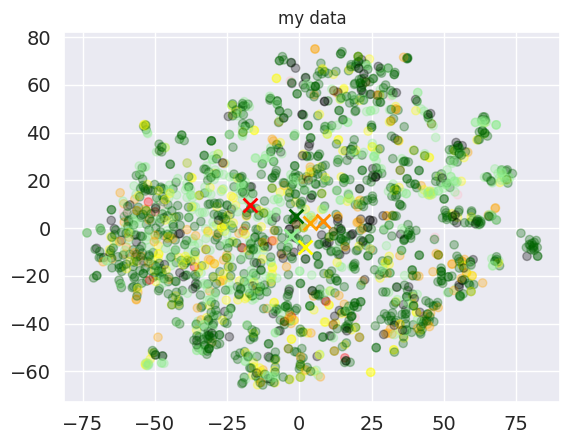

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["darkgreen", "lightgreen", "yellow", "orange", "black", "darkorange", "darkgreen", "red", "pink"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.sizeD_imputed.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4,5,7,8]:
    avg_x = np.array(x)[df.sizeD_imputed-1==score].mean()
    avg_y = np.array(y)[df.sizeD_imputed-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("my data")